In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.optim as optim
from torchvision import models


In [ ]:
#define a transformation function for training and test
train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#create training and test dataset
training = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformation)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformation)

size_batch = 10000
#create training and test loaders
train_loader = torch.utils.data.DataLoader(training, batch_size=size_batch,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=1,shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


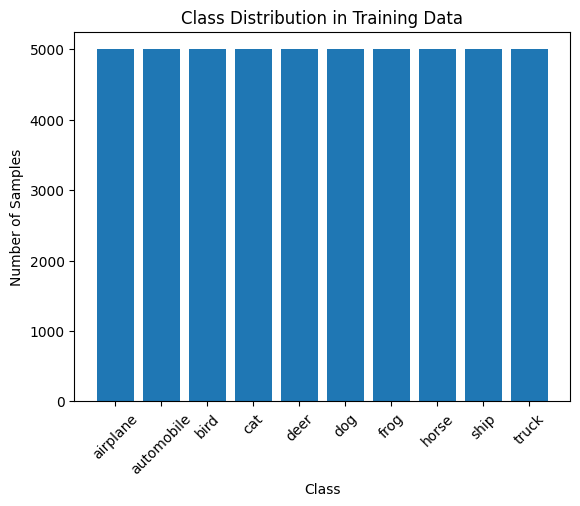

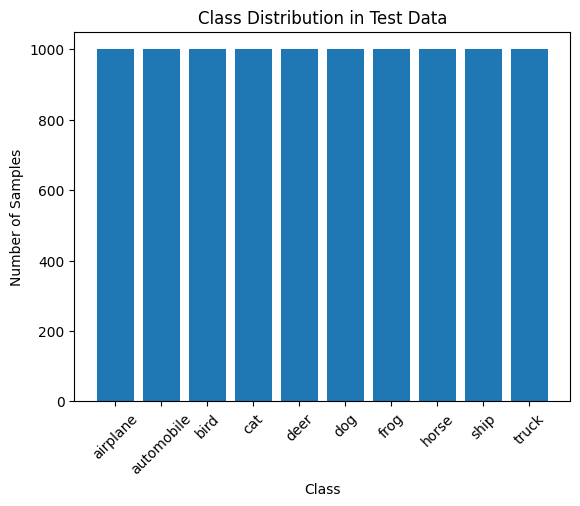

In [ ]:
def check_class_distribution(dataset, loader, name):
    classes = dataset.classes
    num_classes = len(classes)
    class_count = np.zeros(10)  #count occurrences of each class
    shape_image = None
    for images, labels in loader:
        if shape_image is None:
            shape_image = images[0].shape
        for label in labels:
            class_count[label] += 1
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()
    return shape_image, num_classes


#distribution for training data
shape_image_train, num_classes_train = check_class_distribution(training,train_loader, "Training Data")
#distribution for test data
shape_image_test, num_classes_test = check_class_distribution(test, test_loader, "Test Data")

In [ ]:
#sanity check
if shape_image_train == shape_image_test:
  #input_size = torch.prod(torch.tensor(shape_image_train)).item()
  input_size = torch.tensor(shape_image_train)
if num_classes_train == num_classes_test:
  output_size = num_classes_train
print(input_size, output_size)
'''
print(int(input_size[0]))
print(int(input_size[1]))
print(int(input_size[2]))
'''

tensor([ 3, 32, 32]) 10


'\nprint(int(input_size[0]))\nprint(int(input_size[1]))\nprint(int(input_size[2]))\n'

In [ ]:
class Trial_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(input_size[0],input_size[1] , kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(input_size[1])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(input_size[1] ,input_size[1] , kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(input_size[1])
        self.fc1 = nn.Linear(input_size[1] * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        #print("1",x.shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #print("2",x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #print("3",x.shape)
        # Flatten images into vectors
        x = x.view(x.size(0), -1)
        #print("4",x.shape)
        x = F.relu(self.fc1(x))
        #print("5",x.shape)
        x = F.relu(self.fc2(x))
        #print("6",x.shape)
        x = self.fc3(x)
        #print("7",x.shape)
        return x

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
print(device)

cuda


In [ ]:
model = Trial_CIFAR10()
#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise_f_ep100.pth'))

#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_100.pth'))
#model.eval()
model.to(device)
if next(model.parameters()).is_cuda:
    print("model moved to cuda")


model moved to cuda


In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable


def deepfool(model, images, labels, target_labels, steps=50, epsilon=0.001):
    """
    Generate adversarial examples using the DeepFool algorithm for a batch of images.

    Args:
        model (torch.nn.Module): The PyTorch model to attack.
        images (torch.Tensor): Batch of input image tensors (assumes normalized to [0, 1]).
        labels (torch.Tensor): True labels of the images.
        target_labels (torch.Tensor): Target labels to misclassify to.
        steps (int): Number of iterations to find the minimal perturbation.
        epsilon (float): A small constant to avoid division by zero.

    Returns:
        torch.Tensor: Batch of adversarial image tensors.
    """
    # Move images and labels to device (CPU or GPU)
    device = next(model.parameters()).device
    images, labels, target_labels = images.to(device), labels.to(device), target_labels.to(device)

    # Convert images to require gradient computation
    #images = images.clone().detach().requires_grad_(True)
    #images = images.clone().requires_grad_(True)
    #images.requires_grad = True
    image_var = Variable(images.clone(), requires_grad=True)



    # Define optimizer
    #optimizer = torch.optim.Adam([images], lr=0.001)
    optimizer = torch.optim.Adam([image_var], lr=0.001)

    for just_d in range(steps):
        # Forward pass
        #outputs = model(images)
        outputs = model(image_var)

        # Calculate the loss
        loss = F.cross_entropy(outputs, target_labels)

        # Zero gradients, backward pass, and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Retain gradients for computation
        #images.retain_grad()
        image_var.retain_grad()

        # Check if gradients are available
        #if images.grad is None:
        if image_var.grad is None:
            print("image grad is none", just_d)
            break

        # Compute the gradient of the loss w.r.t. the input images
        #gradients = images.grad
        #print('pases this once',just_d)
        gradients = image_var.grad

        # Compute the perturbation using the gradient sign
        perturbation = torch.sign(gradients)

        # Update the images with the perturbation
        #images = images + epsilon * perturbation
        #image_var = image_var + epsilon * perturbation
        image_var.data.add_(epsilon * perturbation)


        # Clip the perturbed images to the valid range [0, 1]
        #images = torch.clamp(images, 0, 1)
        #image_var = torch.clamp(image_var, 0, 1)
        image_var.data.clamp_(0, 1)


        # Check if target label reached for any image in the batch
        if torch.all(torch.eq(torch.argmax(outputs, dim=1), target_labels)):
            break

    # Return the batch of adversarial image tensors
    #return images
    return image_var


In [ ]:
def plot_images(image_tensor1,image_tensor2, l1,l2):
  import matplotlib.pyplot as plt
  import numpy as np


  # Transfer to CPU and convert to NumPy arrays
  image_array1 = image_tensor1.squeeze().cpu().detach().numpy()
  image_array2 = image_tensor2.squeeze().cpu().detach().numpy()

  # Transpose the array to match the order expected by matplotlib (H, W, C)
  image_np = np.transpose(image_array1, (1, 2, 0))
  c = (255*(image_np - np.min(image_np))/np.ptp(image_np)).astype(int)

  image_np2 = np.transpose(image_array2, (1, 2, 0))
  c2 = (255*(image_np2 - np.min(image_np2))/np.ptp(image_np2)).astype(int)


  # Plot the image
  #plt.imshow(c)
  #plt.axis('off')
  #plt.show()


  # Create subplots and display images

  #plt.figure(figsize=(10, 5))

  '''
  # Plot the first image
  plt.subplot(1, 3, 1)
  plt.imshow(c)
  plt.title('Image 1')
  plt.axis('off')

  # Plot the second image
  plt.subplot(1, 3, 2)
  plt.imshow(c2)
  plt.title('Image 2')
  plt.axis('off')

  plt.show()
  '''

  fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Create 1 row, 2 columns
  classes = {0:'plane', 1:'car', 2:'bird', 3:'cat',4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

  axes[0].imshow(c)
  axes[1].imshow(c2)

  axes[0].set_title(f'Original_image: {classes[l1]}')
  axes[1].set_title(f'Deepfool_attacked: {classes[l2]}')

  fig.tight_layout()
  plt.savefig('trial_cifar10_noise_deepfool.png')
  plt.show()


In [ ]:
def adversarial_examples(model, dataloader):
    """Testing the model with adversarial examples and print loss values."""
    image_tensor1,image_tensor2, image_tensor3 = None, None, None
    l1, l2 = 9998, 9999
    batch_id = 99999
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        image_tensor1 = images


        # adversarial examples
        #adv_images = adversarial_noise(images)
        #adv_images2 = FGSM(model,images)
        #adv_images3 = PGD(model,images)
        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)
        #adv_image_cw = cw_attack(model, images, target_label)


        adv_image_df = deepfool(model, images, labels, target_label)
        print(adv_image_df.shape)
        image_tensor2 = adv_image_df

        # original and attacked output label
        outputs_orig = model(images)
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()


        #outputs_adv = model(adv_images)
        #outputs_adv2 = model(adv_images2)
        #outputs_adv3 = model(adv_images3)
        #outputs_cw = model(adv_image_cw)
        outputs_df = model(adv_image_df)

        # loss
        loss_orig = F.cross_entropy(outputs_orig, labels)
        #loss_adv = F.cross_entropy(outputs_adv, labels)
        #loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        #loss_adv3 = F.cross_entropy(outputs_adv3, labels)
        #loss_cw =  F.cross_entropy(outputs_cw, labels)
        loss_df =  F.cross_entropy(outputs_df, labels)
        l1 = labels.cpu().numpy()[0]
        _, predicted = torch.max(outputs_df.data, 1)
        correct_predictions = torch.eq(predicted, labels).sum().item()
        l2 = predicted.cpu().numpy()[0]

        if l1 == l2:

          # labels and loss values
          print("Original labels: ", labels.cpu().numpy())

          print("Loss on original images: ", loss_orig.item())
          #print("Loss on noisy adversarial images: ", loss_adv.item())
          #print("Loss on FGSM images: ", loss_adv2.item())
          #print("Loss on FGSM images: ", loss_adv3.item())
          #_, predicted = torch.max(outputs_cw.data, 1)


          print("target label", target_label.cpu().numpy())
          print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")
          #print("loss on cw", loss_cw)
          print("loss on df", loss_df)
          print("batch_idx", batch_idx)
          batch_id = batch_idx
          break

    #accuracy_orig = correct_predictions_orig / len(labels)
    #print(f"Accuracy: {accuracy_orig}")
    #accuracy = correct_predictions / len(labels)
    #print(f"Accuracy: {accuracy}")
    plot_images(image_tensor1,image_tensor2, l1, l2)
    return batch_id



torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
Original labels:  [8]
Loss on original images:  2.0497429370880127
target label [9]
Predicted Label for Adversarial Image: [8]
loss on df tensor(1.0962, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx 1


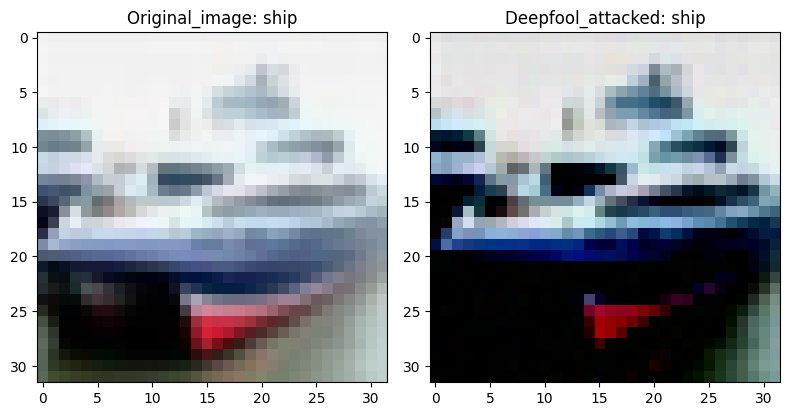

In [ ]:
batch_id = adversarial_examples(model, test_loader)

In [ ]:
#batch_id = 1

In [ ]:
model = Trial_CIFAR10()
#model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_50_noise.pth'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/trial_cifar10_100.pth'))
#model.eval()
model.to(device)
if next(model.parameters()).is_cuda:
    print("model moved to cuda")


model moved to cuda


In [ ]:
def adversarial_examples_match(model, dataloader, batch_id):
    """Testing the model with adversarial examples and print loss values."""
    image_tensor1,image_tensor2, image_tensor3 = None, None, None
    l1, l2 = 9998, 9999
    for batch_idx, (images, labels) in enumerate(dataloader):
      if batch_idx == batch_id:
          images, labels = images.to(device), labels.to(device)
          image_tensor1 = images


          # adversarial examples
          #adv_images = adversarial_noise(images)
          #adv_images2 = FGSM(model,images)
          #adv_images3 = PGD(model,images)
          target_label = (labels + 1) % output_size
          target_label = target_label.to(device)
          #adv_image_cw = cw_attack(model, images, target_label)


          adv_image_df = deepfool(model, images, labels, target_label)
          print(adv_image_df.shape)
          image_tensor2 = adv_image_df

          # original and attacked output label
          outputs_orig = model(images)
          _, predicted_orig = torch.max(outputs_orig.data, 1)
          correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()


          #outputs_adv = model(adv_images)
          #outputs_adv2 = model(adv_images2)
          #outputs_adv3 = model(adv_images3)
          #outputs_cw = model(adv_image_cw)
          outputs_df = model(adv_image_df)

          # loss
          loss_orig = F.cross_entropy(outputs_orig, labels)
          #loss_adv = F.cross_entropy(outputs_adv, labels)
          #loss_adv2 = F.cross_entropy(outputs_adv2, labels)
          #loss_adv3 = F.cross_entropy(outputs_adv3, labels)
          #loss_cw =  F.cross_entropy(outputs_cw, labels)
          loss_df =  F.cross_entropy(outputs_df, labels)
          l1 = labels.cpu().numpy()[0]
          _, predicted = torch.max(outputs_df.data, 1)
          correct_predictions = torch.eq(predicted, labels).sum().item()
          l2 = predicted.cpu().numpy()[0]

          #if l1 == l2:

          # labels and loss values
          print("Original labels: ", labels.cpu().numpy())

          print("Loss on original images: ", loss_orig.item())
          #print("Loss on noisy adversarial images: ", loss_adv.item())
          #print("Loss on FGSM images: ", loss_adv2.item())
          #print("Loss on FGSM images: ", loss_adv3.item())
          #_, predicted = torch.max(outputs_cw.data, 1)


          print("target label", target_label.cpu().numpy())
          print(f"Predicted Label for Adversarial Image: {predicted.cpu().numpy()}")
          #print("loss on cw", loss_cw)
          print("loss on df", loss_df)
          print("batch_idx", batch_idx)
          break

    #accuracy_orig = correct_predictions_orig / len(labels)
    #print(f"Accuracy: {accuracy_orig}")
    #accuracy = correct_predictions / len(labels)
    #print(f"Accuracy: {accuracy}")
    plot_images(image_tensor1,image_tensor2, l1, l2)



torch.Size([1, 3, 32, 32])
Original labels:  [8]
Loss on original images:  2.5521187782287598
target label [9]
Predicted Label for Adversarial Image: [0]
loss on df tensor(2.1159, device='cuda:0', grad_fn=<NllLossBackward0>)
batch_idx 1


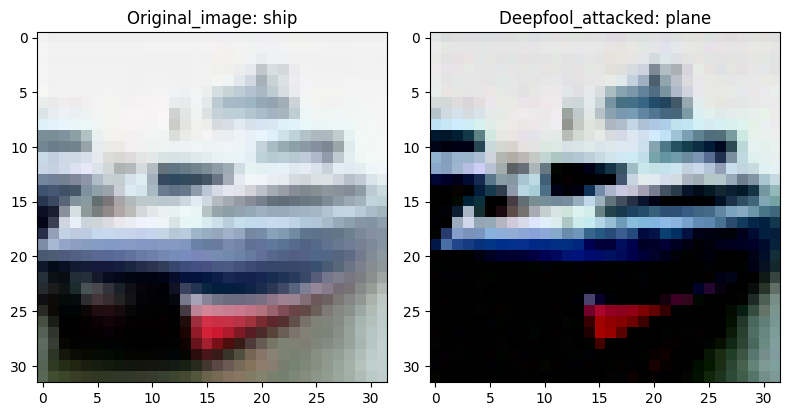

In [ ]:
adversarial_examples_match(model, test_loader, batch_id)